In [1]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [2]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import numpy as np
import pandas as pd
import joblib
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)
## np.warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
np.seterr(all="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
from src.p7_full_kernel import get_full_data, kfold_lightgbm_sklearn
from src.p7_simple_kernel import get_simple_data
from src.p7_simple_kernel import CONFIG_SIMPLE
from src.p7_util import timer
from src.p7_constantes import (
    NUM_THREADS,
    DATA_BASE,
    DATA_INTERIM,
)

%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

# Configuration

In [4]:
print("NUM_THREADS :", NUM_THREADS)


NUM_THREADS : 16


In [5]:
shape_application_train = pd.read_csv(os.path.join(DATA_BASE, "application_train.csv")).shape
print(shape_application_train)

(307511, 122)


# Full Kernel

## One Hot uniquement

Joindre et nettoyer les données

In [6]:
with timer("Pipeline total time"):
    df = get_full_data(debug=False, ohe=True)

e:\Mes Documents\_Open Classroom\Code\p7\src\p7_full_kernel.py:540: RuntimeWarning: All-NaN slice encountered
  df[feature_name] = eval("np.{}".format(function_name))(


Application dataframe shape:  (356250, 211)
application_train and application_test - duration (hh:mm:ss) : 0:00:06
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - duration (hh:mm:ss) : 0:00:14
Previous dataframe shape:  (338857, 225)
previous_application - duration (hh:mm:ss) : 0:00:20
Pos-cash dataframe shape:  (337252, 24)
Installments dataframe shape:  (339587, 101)
Credit card dataframe shape:  (103558, 59)
previous applications balances - duration (hh:mm:ss) : 0:07:42
Initial df memory usage is 1806.09 MB for 787 columns
Final memory usage is: 805.54 MB - decreased by 55.4%
Pipeline total time - duration (hh:mm:ss) : 0:08:26


Information

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356250 entries, 0 to 356249
Columns: 787 entries, SK_ID_CURR to DAYS_CREDIT_MEAN_TO_EMPLOYED
dtypes: float16(482), float32(235), float64(56), int16(2), int32(1), int8(11)
memory usage: 805.5 MB


In [8]:
df.shape

(356250, 787)

Sauvegarde

In [9]:
df.to_csv(os.path.join(DATA_INTERIM, "all_data_full_kernel_ohe.csv"))

## Label Encoding in application table

Joindre et nettoyer les données

In [10]:
with timer("Pipeline total time"):
    df = get_full_data(debug=False, ohe=False)

e:\Mes Documents\_Open Classroom\Code\p7\src\p7_full_kernel.py:540: RuntimeWarning: All-NaN slice encountered
  df[feature_name] = eval("np.{}".format(function_name))(


Application dataframe shape:  (356250, 83)
application_train and application_test - duration (hh:mm:ss) : 0:00:06
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - duration (hh:mm:ss) : 0:00:14
Previous dataframe shape:  (338857, 225)
previous_application - duration (hh:mm:ss) : 0:00:21
Pos-cash dataframe shape:  (337252, 24)
Installments dataframe shape:  (339587, 101)
Credit card dataframe shape:  (103558, 59)
previous applications balances - duration (hh:mm:ss) : 0:07:35
Initial df memory usage is 1791.14 MB for 659 columns
Final memory usage is: 714.49 MB - decreased by 60.1%
Pipeline total time - duration (hh:mm:ss) : 0:08:19


Information

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356250 entries, 0 to 356249
Columns: 659 entries, SK_ID_CURR to DAYS_CREDIT_MEAN_TO_EMPLOYED
dtypes: float16(342), float32(235), float64(56), int16(2), int32(1), int8(23)
memory usage: 714.5 MB


In [12]:
df.shape

(356250, 659)

In [13]:
cat_features = df.select_dtypes(include='object').columns.tolist()
cat_features

[]

In [14]:
df.to_csv(os.path.join(DATA_INTERIM, "all_data_full_kernel_le.csv"))
joblib.dump(cat_features, os.path.join(DATA_INTERIM, "cat_features_full_kernel_le.pkl"))

['data/interim/cat_features_full_kernel_le.pkl']

# Simple Kernel (OHE)

Configuration

In [24]:
CONFIG_SIMPLE

{'debug': False,
 'nan_as_cat': True,
 'data_output_dir': 'data/interim/',
 'data_filename': 'all_data_simple_kernel_ohe.csv',
 'generate_submission_files': True,
 'model_dir': 'models/',
 'model_subdir': 'light_simple/',
 'importance_filename': 'feature_importance.csv',
 'submission_filename': 'lightgbm_simple_submission.csv',
 'num_threads': 16,
 'stratified_kfold': True,
 'num_folds': 10,
 'early_stopping': 100,
 'random_seed': 1001}

In [25]:
config = CONFIG_SIMPLE
print("Debug =", config["debug"])
print("NaN as category =", config["nan_as_cat"])
print("Data filepath =", os.path.join(config["data_output_dir"], config["data_filename"]))

Debug = False
NaN as category = True
Data filepath = data/interim/all_data_simple_kernel_ohe.csv


In [26]:
config["debug"] = False

Joindre et nettoyer les données

In [27]:
with timer("Pipeline total time"):
    df, test = get_simple_data(config)

data/interim/ dossier déjà existant
Data samples: 307511
Application df shape: (307511, 256)
Process Application - duration (hh:mm:ss) : 0:00:02
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - duration (hh:mm:ss) : 0:00:11
Previous applications df shape: (338857, 249)
Process previous_applications - duration (hh:mm:ss) : 0:00:11
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - duration (hh:mm:ss) : 0:00:06
Installments payments df shape: (339587, 26)
Process installments payments - duration (hh:mm:ss) : 0:00:14
Credit card balance df shape: (103558, 125)
Process credit card balance - duration (hh:mm:ss) : 0:00:09
Remplacement des valeurs infinies par NaN - duration (hh:mm:ss) : 0:00:00
write data

Taille du jeu de test : (76878, 790), sauvegardé dans data/interim/v0_test.csv
Taille du jeu de Train : (230633, 790), 1175 Mo. Sauvegardé dans data/interim/v0_train.csv
Partage Train Test(25%) - duration (hh:mm:ss) : 0:01:06
Pipeline total time - duration

Information

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230633 entries, 85650 to 42906
Columns: 790 entries, SK_ID_CURR to TARGET
dtypes: bool(141), float64(607), int64(42)
memory usage: 1.1 GB


In [29]:
df.shape

(230633, 790)

In [30]:
df['CODE_GENDER'].value_counts(dropna=False)

CODE_GENDER
1.0    151901
0.0     78730
NaN         2
Name: count, dtype: int64

In [31]:
# Doublons dans les noms de features ?
features = df.columns.tolist()
print(len(features))
print(len(set(features)))

790
790


In [14]:
df.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Sentproposal_SUM,CC_NAME_CONTRACT_STATUS_Sentproposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,TARGET
85650,199392,0.0,1,1,1,225000.0,270000.0,13500.0,270000.0,0.008625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
212385,346123,1.0,0,0,0,540000.0,2013840.0,53253.0,1800000.0,0.016612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
35384,140985,1.0,0,1,0,103500.0,239850.0,23364.0,225000.0,0.024610,...,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,1.0,0
47464,154964,0.0,0,0,1,135000.0,473760.0,53451.0,450000.0,0.010006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0
172378,299752,0.0,0,0,1,216000.0,1714833.0,59737.5,1566000.0,0.025164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Features de variance nulle

In [15]:
df.shape

(230633, 790)

In [48]:
from src.p7_simple_kernel import get_memory_consumed
from src.p7_feature_selection import DataSelector
from src.p7_simple_kernel import LIGHTGBM_PARAMS_SIMPLE
from src.p7_evaluate import lgb_cross_evaluate

In [46]:
LIGHTGBM_PARAMS_SIMPLE

{'debug': False,
 'nan_as_cat': True,
 'data_output_dir': 'data/interim/',
 'data_filename': 'all_data_simple_kernel_ohe.csv',
 'generate_submission_files': True,
 'model_dir': 'models/',
 'model_subdir': 'light_simple/',
 'importance_filename': 'feature_importance.csv',
 'submission_filename': 'lightgbm_simple_submission.csv',
 'num_threads': 16,
 'stratified_kfold': True,
 'num_folds': 10,
 'early_stopping': 100,
 'random_seed': 1001}

In [34]:
train = pd.read_csv(os.path.join(DATA_INTERIM, "v0_train.csv"))
print("Train :", train.shape)
test = pd.read_csv(os.path.join(DATA_INTERIM, "v0_test.csv"))
print("Test :", test.shape)

Train : (230633, 790)
Test : (76878, 790)


In [35]:
ds = DataSelector(train, test)

In [36]:
_ = ds.drop_null_std()

33 features de variance nulle suppimées dans Train et Test
Nouvelle taille du jeu de Train : (230633, 757), 1123 Mo


In [40]:
ds.save_data("v1_train.csv", "v1_test.csv")

Le fichier data/interim/v1_train.csv sauvegardé. Forme (230633, 757)
Le fichier data/interim/v1_test.csv sauvegardé. Forme (76878, 757)


In [72]:
df = ds.train
#lgb_cross_evaluate(df, params=LIGHTGBM_PARAMS_SIMPLE)

In [52]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

In [ ]:
#df = df.set_index("SK_ID_CURR")

In [88]:
def check_df(X):
    print("Valeurs infinies :\n", np.isinf(X).sum())
    print("Valeurs non numériques :\n", X.applymap(lambda x: not isinstance(x, (int, float))).sum())
    return

In [73]:
features = df.columns.tolist()
features.remove("TARGET")
features.remove("SK_ID_CURR")
X = df[features]
y = df['TARGET']
X.shape

(230633, 755)

In [76]:
y.isnull().sum()

0

In [77]:
y.isna().sum()

0

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [94]:
type(X_val)

pandas.core.frame.DataFrame

In [95]:
check_df(X_train)
check_df(X_val)

Valeurs infinies :
 CODE_GENDER                                 0
FLAG_OWN_CAR                                0
FLAG_OWN_REALTY                             0
CNT_CHILDREN                                0
AMT_INCOME_TOTAL                            0
                                           ..
CC_NAME_CONTRACT_STATUS_Sentproposal_VAR    0
CC_NAME_CONTRACT_STATUS_Signed_MEAN         0
CC_NAME_CONTRACT_STATUS_Signed_SUM          0
CC_NAME_CONTRACT_STATUS_Signed_VAR          0
CC_COUNT                                    0
Length: 755, dtype: int64
Valeurs non numériques :
 CODE_GENDER                                 0
FLAG_OWN_CAR                                0
FLAG_OWN_REALTY                             0
CNT_CHILDREN                                0
AMT_INCOME_TOTAL                            0
                                           ..
CC_NAME_CONTRACT_STATUS_Sentproposal_VAR    0
CC_NAME_CONTRACT_STATUS_Signed_MEAN         0
CC_NAME_CONTRACT_STATUS_Signed_SUM          0
CC_NAME_

In [78]:
# Convertir les bool en int
var_bool = df.select_dtypes("bool").columns
len(var_bool)

0

In [84]:
df[var_bool] = df[var_bool].astype(int)
X[var_bool] = X[var_bool].astype(int)

In [67]:
get_memory_consumed(df)

Taille mémoire du DataFrame : 1212 Mo


1212

In [96]:



params = {
    "random_state": 42,
    "nthread": 8,
}
clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS_SIMPLE})

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric="auc",
    # verbose=200,
    callbacks=[lgb.early_stopping(50)],
    n_jobs=16,
)

"""oof_preds[valid_idx] = clf.predict_proba(
    valid_x, num_iteration=clf.best_iteration_
)[:, 1]"""


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1284]	training's auc: 0.894863	training's binary_logloss: 0.192957	valid_1's auc: 0.784343	valid_1's binary_logloss: 0.238391


'oof_preds[valid_idx] = clf.predict_proba(\n    valid_x, num_iteration=clf.best_iteration_\n)[:, 1]'

In [97]:
clf.best_iteration_

1284

In [99]:
params = clf.get_params()
params['n_estimators'] = clf.best_iteration_

In [101]:
clf = LGBMClassifier(**params)

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric="auc",
    # verbose=200,
    callbacks=[lgb.early_stopping(50)],
)


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1284]	training's auc: 0.894863	training's binary_logloss: 0.192957	valid_1's auc: 0.784343	valid_1's binary_logloss: 0.238391


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=1284, nthread=8, num_leaves=34, random_state=42,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [105]:
from sklearn.inspection import permutation_importance
import copy

In [111]:
fitted_clf = copy.deepcopy(clf)

In [112]:
result = permutation_importance(
    fitted_clf, X_val, y_val, n_repeats=3, random_state=42, n_jobs=16
)

In [115]:
len(result)

3

In [116]:
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [117]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

importances.head()

,PREV_CNT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MEAN,INCOME_CREDIT_PERC,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,INSTAL_AMT_PAYMENT_MAX,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,...,INSTAL_DPD_MEAN,OWN_CAR_AGE,PAYMENT_RATE,CODE_GENDER,DAYS_EMPLOYED,INSTAL_AMT_PAYMENT_SUM,AMT_GOODS_PRICE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2
0,-0.000139,-0.000208,-0.000156,-0.000191,-0.000139,-0.000052,0.000069,-0.000087,-0.000052,-0.000069,...,-0.000017,0.000208,0.000295,0.000208,0.000451,0.000364,0.000468,0.000416,0.000624,0.001231
1,-0.000191,-0.000260,-0.000104,-0.000173,-0.000121,-0.000156,-0.000208,-0.000087,-0.000104,-0.000121,...,0.000277,0.000191,0.000035,0.000156,0.000087,0.000191,0.000104,0.000555,0.000746,0.000867
2,-0.000364,-0.000225,-0.000156,-0.000017,-0.000069,-0.000104,-0.000173,-0.000121,-0.000121,-0.000087,...,0.000260,0.000139,0.000243,0.000347,0.000191,0.000208,0.000225,0.000468,0.000451,0.001023


In [124]:
# Top 40 des plus importantes
top = 20
most_important_features = importances.columns[-top:]
len(most_important_features)

20

In [125]:
most_important_features

Index(['POS_MONTHS_BALANCE_MAX', 'ACTIVE_DAYS_CREDIT_MAX',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
       'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
       'PREV_APP_CREDIT_PERC_MEAN', 'NAME_FAMILY_STATUS_Married',
       'INSTAL_PAYMENT_DIFF_MEAN', 'AMT_ANNUITY', 'DAYS_BIRTH',
       'INSTAL_DPD_MEAN', 'OWN_CAR_AGE', 'PAYMENT_RATE', 'CODE_GENDER',
       'DAYS_EMPLOYED', 'INSTAL_AMT_PAYMENT_SUM', 'AMT_GOODS_PRICE',
       'EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2'],
      dtype='object')

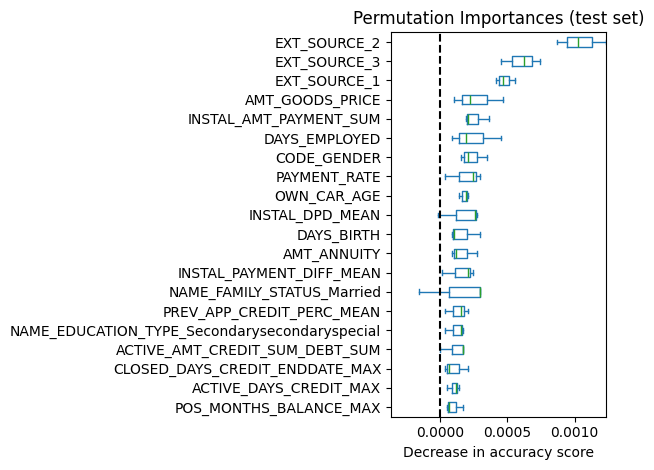

In [129]:
min_importance = importances.min().min()
max_importance = importances.max().max()
ax = importances[most_important_features].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.set_xlim(min_importance, max_importance)
ax.figure.tight_layout()

In [130]:
# Top 40 des moins importantes
bottom = top
less_important_features = importances.columns[:bottom]
less_important_features

Index(['PREV_CNT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_MEAN',
       'INCOME_CREDIT_PERC', 'PREV_NAME_YIELD_GROUP_low_action_MEAN',
       'PREV_AMT_DOWN_PAYMENT_MAX', 'CC_CNT_DRAWINGS_CURRENT_MEAN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN', 'INSTAL_AMT_PAYMENT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM', 'PREV_RATE_DOWN_PAYMENT_MEAN',
       'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN', 'APPROVED_APP_CREDIT_PERC_MIN',
       'APPROVED_AMT_ANNUITY_MEAN', 'APPROVED_AMT_ANNUITY_MIN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM',
       'APPROVED_CNT_PAYMENT_MEAN', 'APPROVED_CNT_PAYMENT_SUM',
       'REFUSED_DAYS_DECISION_MIN'],
      dtype='object')

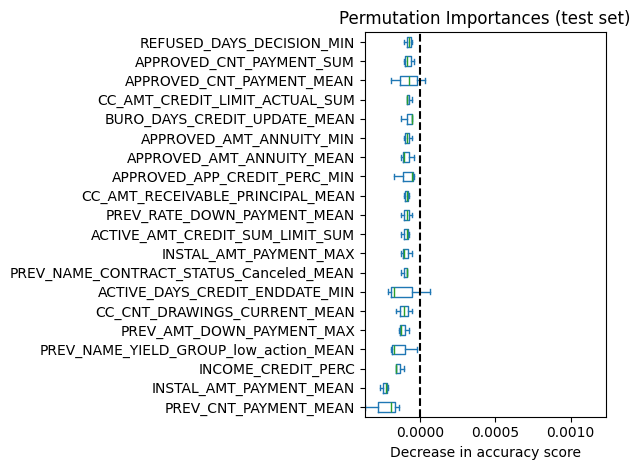

In [132]:
ax = importances[less_important_features].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.set_xlim(min_importance, max_importance)
ax.figure.tight_layout()

In [134]:
# Moyenne des moyennes
mean_importance = np.mean(result['importances_mean'])
mean_importance

7.435050412647598e-06

In [147]:
# Importances négatives
importances_mean = pd.DataFrame(result['importances_mean'], index=X.columns, columns=['importance'])
importances_mean.head()


,importance
CODE_GENDER,0.000237
FLAG_OWN_CAR,0.000012
FLAG_OWN_REALTY,-0.000012
CNT_CHILDREN,0.000006
AMT_INCOME_TOTAL,-0.000029


In [149]:
negative_features = importances_mean[importances_mean['importance'] < 0].index.tolist()
len(negative_features)

223

In [ ]:
"""
I. Interprétation des Importances 

1) Impact Négatif sur les Performances :
Une importance moyenne négative pour une caractéristique signifie que, 
lorsque les valeurs de cette caractéristique sont permutées (c'est-à-dire réarrangées au hasard), 
les performances du modèle s'améliorent plutôt que de se dégrader. En d'autres termes, 
le modèle se comporte mieux sans la structure d'origine de cette caractéristique.

2) Indicateur de Bruit ou d'Information Trompeuse :
Cela peut indiquer que la caractéristique en question introduit du bruit ou de l'information trompeuse dans le modèle, 
ce qui nuit à la capacité du modèle à faire des prédictions précises. 
En d'autres termes, la caractéristique pourrait être nuisible.

II. Raisons Potentielles

1) Multicolinéarité :
Si la caractéristique est fortement corrélée avec une ou plusieurs autres caractéristiques, 
elle peut introduire de la redondance ou même de la confusion dans le modèle.

2) Caractéristique Non Pertinente :
La caractéristique peut être non pertinente pour la tâche de prédiction, et sa présence peut introduire du bruit.

3) Petite Taille de l'Échantillon.
"""

In [44]:
df1 = ds.reduce_memory_usage()

Memory usage of dataframe is 1122.62 MB
Memory usage after optimization is: 1122.62 MB
Decreased by 0.0%


In [32]:
get_memory_consumed(df)

Taille mémoire du DataFrame : 1175 Mo


1175

In [18]:
predictors = [feature for feature in df.columns if feature not in ['SK_ID_CURR', 'TARGET']]
len(predictors)

788

In [21]:
std = df[predictors].std().sort_values()

In [23]:
features_null_std = std[std == 0.0]
print(f"{features_null_std.shape[0]} features ont une variance nulle")
features_null_std

33 features ont une variance nulle


PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN               0.0
PREV_CHANNEL_TYPE_nan_MEAN                         0.0
PREV_NAME_PRODUCT_TYPE_nan_MEAN                    0.0
PREV_NAME_PAYMENT_TYPE_nan_MEAN                    0.0
NAME_HOUSING_TYPE_nan                              0.0
PREV_NAME_SELLER_INDUSTRY_nan_MEAN                 0.0
PREV_NAME_YIELD_GROUP_nan_MEAN                     0.0
PREV_NAME_PORTFOLIO_nan_MEAN                       0.0
BURO_STATUS_nan_MEAN_MEAN                          0.0
PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN          0.0
PREV_CODE_REJECT_REASON_nan_MEAN                   0.0
PREV_NAME_GOODS_CATEGORY_nan_MEAN                  0.0
NAME_EDUCATION_TYPE_nan                            0.0
NAME_INCOME_TYPE_nan                               0.0
CC_SK_DPD_MIN                                      0.0
PREV_NAME_CONTRACT_STATUS_nan_MEAN                 0.0
WEEKDAY_APPR_PROCESS_START_nan                     0.0
BURO_CREDIT_TYPE_nan_MEAN                          0.0
PREV_NAME_

Sauvegarde

In [13]:
#df.to_csv(config["data_filepath"])